In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import rawpy
from datetime import datetime
from torch.utils.data import Dataset
from utils import get_time, imp_cont_img
import matplotlib.pyplot as plt
from dataset import Asbest_regression

In [2]:
path = 'asbest/transporter/'
img = cv2.imread('asbest/transporter/2020.03.16/1_11:32:12_16-03-2020_0.png', cv2.IMREAD_UNCHANGED)
img_shape = img.shape

train_data = Asbest_regression(path, subset='train', num_frames=2000, crop_size=(img_shape[0] // 2, img_shape[1] // 2), img_size=(448, 448))
valid_data = Asbest_regression(path, subset='valid', num_frames=300, crop_size=(img_shape[0] // 2, img_shape[1] // 2), img_size=(448, 448))

100%|██████████| 300/300 [00:38<00:00,  7.88it/s]


Text(0.5, 1.0, '0.618')

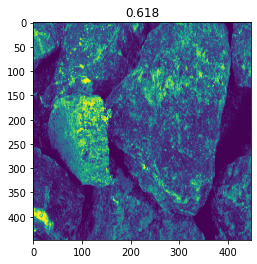

In [3]:
index = 73
plt.imshow(train_data.images[index])
plt.title(train_data.labels[index])

In [4]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [5]:
import torch
from torch import nn
from torchvision.models import resnet34, resnet50, mobilenet_v2
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, net=None, channels=1, pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = models.mobilenet_v2(pretrained=True)
            # code here
        elif self.net == 'resnet34':
            self.model = models.resnet34(pretrained=True)
            # code here
        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained=True)
        else:
            conv1_1 = nn.Conv2d(1, 32, 3, padding=1)
            bn1_1 = nn.BatchNorm2d(32)
            conv1_2 = nn.Conv2d(32, 32, 3, padding=1)
            bn1_2 = nn.BatchNorm2d(32)
            maxpool = nn.MaxPool2d(2)
            conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
            bn2_1 = nn.BatchNorm2d(64)
            conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
            bn2_2 = nn.BatchNorm2d(64)
#             self.maxpool = nn.MaxPool2d(2)
            conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
            bn3_1 = nn.BatchNorm2d(128)
            conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
            bn3_2 = nn.BatchNorm2d(128)
            conv4_1 = nn.Conv2d(128, 256, 3, padding=1)
            bn4_1 = nn.BatchNorm2d(256)
            conv4_2 = nn.Conv2d(256, 256, 3, padding=1)
            bn4_2 = nn.BatchNorm2d(256)
            conv5_1 = nn.Conv2d(256, 512, 3, padding=1)
            bn5_1 = nn.BatchNorm2d(512)
            conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
            bn5_2 = nn.BatchNorm2d(512)
            
            self.encoder = torch.nn.Sequential(
                conv1_1,
                nn.ReLU(),
                bn1_1,
                conv1_2,
                nn.ReLU(),
                bn1_2,
                maxpool,
                conv2_1,
                nn.ReLU(),
                bn2_1,
                conv2_2,
                nn.ReLU(),
                bn2_2,
                maxpool,
                conv3_1,
                nn.ReLU(),
                bn3_1,
                conv3_2,
                nn.ReLU(),
                bn3_2,
                maxpool,
                conv4_1,
                nn.ReLU(),
                bn4_1,
                conv4_2,
                nn.ReLU(),
                bn4_2,
                maxpool,
                conv5_1,
                nn.ReLU(),
                bn5_1,
                conv5_2,
                nn.ReLU(),
                bn5_2,
            )
#             self.conv = nn.Conv2d(256, 256, (28, 28))
            self.avr = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(512, 1, bias=False)
            self.sigmoid = nn.Sigmoid()
            
#         self.model.conv1.in_channels = 1
#         self.model.fc.out_features = 1

    def forward(self, x):
        if self.net == 'resnet34':
            x = self.model(x)
        elif self.net == None:
            x = self.encoder(x)
#             x = self.conv(x)
            x = self.avr(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            x = self.sigmoid(x)
            
        return x
#             x = self.model.conv1(x)
#             x = self.model.bn1(x)
#             x = self.model.relu(x)
#             x = self.model.maxpool(x)
#             x = self.model.layer1(x)
#             x = self.model.layer2(x)
#             x = self.model.layer3(x)
#             x = self.model.layer4(x)
#             x = self.model.avgpool(x)
#             x = x.view(x.size(0), -1)
#             gender = self.model.gender_cls(x)

        
#         return gender

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

In [7]:
from torchsummary import summary 
summary(model, (1,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 448, 448]             320
              ReLU-2         [-1, 32, 448, 448]               0
       BatchNorm2d-3         [-1, 32, 448, 448]              64
            Conv2d-4         [-1, 32, 448, 448]           9,248
              ReLU-5         [-1, 32, 448, 448]               0
       BatchNorm2d-6         [-1, 32, 448, 448]              64
         MaxPool2d-7         [-1, 32, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          18,496
              ReLU-9         [-1, 64, 224, 224]               0
      BatchNorm2d-10         [-1, 64, 224, 224]             128
           Conv2d-11         [-1, 64, 224, 224]          36,928
             ReLU-12         [-1, 64, 224, 224]               0
      BatchNorm2d-13         [-1, 64, 224, 224]             128
        MaxPool2d-14         [-1, 64, 1

In [8]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
from tqdm import tqdm
# inputs = Variable(x)
# outputs = Variable(y)

epochs = 100

for epoch in range(epochs):
    
    average_total_loss = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f}', 
              postfix=[0, 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, labels = data
            
            inputs=inputs.to(device).float()
            labels=labels.to(device).float()
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels) 
            loss.backward()        
            optimizer.step()
            
            average_total_loss.update(loss.data.item())
            
            t.postfix[1] = average_total_loss.average()
            t.update()
    ## Validation
    val_average_total_loss = AverageMeter()
    
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f}', 
              postfix=[0, 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:

            torch.cuda.empty_cache()
            inputs, labels = data
            
            inputs=inputs.to(device).float()
            labels=labels.to(device).float()
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels) 
            loss.backward()        
            optimizer.step()

            val_average_total_loss.update(loss.data.item())
            
            t.postfix[1] = val_average_total_loss.average()
            t.update()
#    if i % 10 == 0:
#        # plot and show learning process
#        plt.cla()
#        plt.scatter(x.data.numpy(), y.data.numpy())
#        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
#        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
#        plt.pause(0.1)

# plt.show()

Training epoch 1 | 250/250 00:54<00:00 | loss : 0.0571
Validation epoch 1 | 38/38 00:08<00:00 | loss : 0.0272
Training epoch 2 | 250/250 00:54<00:00 | loss : 0.0472
Validation epoch 2 | 38/38 00:08<00:00 | loss : 0.0205
Training epoch 3 | 250/250 00:54<00:00 | loss : 0.0444
Validation epoch 3 | 38/38 00:08<00:00 | loss : 0.0245
Training epoch 4 | 250/250 00:54<00:00 | loss : 0.0459
Validation epoch 4 | 38/38 00:08<00:00 | loss : 0.0231
Training epoch 5 | 250/250 00:54<00:00 | loss : 0.0435
Validation epoch 5 | 38/38 00:08<00:00 | loss : 0.0251
Training epoch 6 | 250/250 00:54<00:00 | loss : 0.0422
Validation epoch 6 | 38/38 00:08<00:00 | loss : 0.0209
Training epoch 7 | 250/250 00:54<00:00 | loss : 0.0451
Validation epoch 7 | 38/38 00:08<00:00 | loss : 0.0159
Training epoch 8 | 250/250 00:54<00:00 | loss : 0.0385
Validation epoch 8 | 38/38 00:08<00:00 | loss : 0.0191
Training epoch 9 | 250/250 00:54<00:00 | loss : 0.0372
Validation epoch 9 | 38/38 00:08<00:00 | loss : 0.0235
Training e

In [11]:
labels

tensor([[0.6340],
        [0.3780],
        [0.3780],
        [0.4580]], device='cuda:0')

In [12]:
model(inputs)

tensor([[0.5590],
        [0.5215],
        [0.4821],
        [0.5145]], device='cuda:0', grad_fn=<SigmoidBackward>)